In [2]:
import os
from pathlib import Path


In [3]:
%pwd

'/home/hawobade/MLOps/Anomaly-Detection-System-in-Network-Traffic/research'

In [4]:
%cd ../

/home/hawobade/MLOps/Anomaly-Detection-System-in-Network-Traffic


In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

In [6]:
ls-la ../artifacts/data_ingestion/cicdataset/MachineLearningCSV/MachineLearningCVE

ls: cannot access '../artifacts/data_ingestion/cicdataset/MachineLearningCSV/MachineLearningCVE': No such file or directory


In [7]:
data_dir = Path('artifacts/data_ingestion/cicdataset')
csv_files = list(data_dir.glob(r'*/*/*.csv'))

In [8]:
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)    

In [9]:
data_dir = Path('artifacts/data_ingestion/cicdataset')
csv_files = list(data_dir.glob(r'*/*/*.csv'))
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)    

In [10]:
df.shape

(2830743, 79)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [12]:
df.isna().sum()

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64

In [13]:
print('Shape before removing inf, -inf values and nan values: ', df.shape)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print('Shape after removing inf, -inf values and nan values: ', df.shape)

Shape before removing inf, -inf values and nan values:  (2830743, 79)
Shape after removing inf, -inf values and nan values:  (2827876, 79)


In [14]:
df.columns = df.columns.str.strip()


In [15]:
df.Label.value_counts()

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [16]:
df_experiment = df.copy()
df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)
df_experiment.Label.value_counts()

Label
BENIGN          2271320
DoS              251712
PortScan         158804
DDoS             128025
Brute Force       13832
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

<Axes: xlabel='Label'>

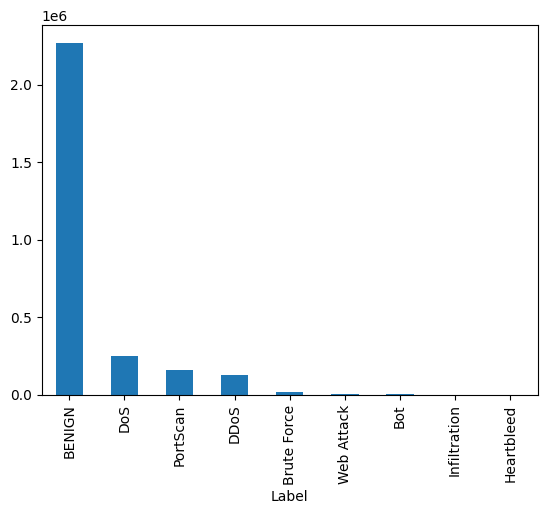

In [17]:
df_experiment['Label'].value_counts().plot(kind='bar')

In [18]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataValidationConfig:
    root_dir: Path
    STATUS_FILE: str
    unzip_data_dir: Path
    all_schema: dict
    merged_csv_file: Path
    

In [19]:
from anomalyDetection.constants import *
from anomalyDetection.utils.common import read_yaml, create_directories
from anomalyDetection import logger

In [20]:
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH, schema_filepath=SCHEMA_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_validation_config(self) -> DataValidationConfig:
        config = self.config.data_validation
        schema = self.schema.COLUMNS

        create_directories([config.root_dir])

        data_validation_config = DataValidationConfig(
            root_dir=config.root_dir,
            all_schema=schema,
            STATUS_FILE=config.STATUS_FILE,
            merged_csv_file=config.merged_csv_file,
            unzip_data_dir=config.unzip_data_dir
        )
        return data_validation_config

In [35]:
class DataValidation:
    def __init__(self, config: DataValidationConfig):
        self.config = config 

    def merge_all_csv(self) -> None:
        try:
            if os.path.isfile(self.config.merged_csv_file):
                logger.info(f"Merged csv file already exists at {self.config.merged_csv_file}")
            else:
                data_dir = Path(self.config.unzip_data_dir)
                csv_files = list(data_dir.glob(r'*/*/*.csv'))
                df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)  
                df.columns = df.columns.str.strip()
                df.to_csv(self.config.merged_csv_file, index=False)
                logger.info(f'Merged {len(csv_files)} csv files into) {self.config.merged_csv_file}')
        except Exception as e:
            raise e

    def validate_all_columns(self) -> bool:
        try: 
            validation_status = None

            data = pd.read_csv(self.config.merged_csv_file)
            all_cols = data.columns.tolist()

            all_schema = self.config.all_schema.keys()

            for col in all_cols:
                if col not in all_schema or data[col].dtype != self.config.all_schema[col]:
                    validation_status = False
                    with open(self.config.STATUS_FILE, 'w') as f:
                        f.write(f"Validation status: {validation_status}")
                else:
                    validation_status = True
                    with open(self.config.STATUS_FILE, 'w') as f:
                        f.write(f"Validation status: {validation_status}")
            return validation_status
        except Exception as e:
            raise e

In [37]:
try:
    config = ConfigurationManager()
    data_validation_config = config.get_data_validation_config()
    data_validation = DataValidation(data_validation_config)
    data_validation.merge_all_csv()
    data_validation.validate_all_columns()
except Exception as e:
    raise e

[2023-10-20 22:15:36,254: INFO: common: yaml file: config/config.yaml loaded successfully]
[2023-10-20 22:15:36,288: INFO: common: yaml file: params.yaml loaded successfully]


[2023-10-20 22:15:36,318: INFO: common: yaml file: schema.yaml loaded successfully]
[2023-10-20 22:15:36,324: INFO: common: created directory at: artifacts]
[2023-10-20 22:15:36,326: INFO: common: created directory at: artifacts/data_validation]
[2023-10-20 22:15:36,329: INFO: 954756971: Merged csv file already exists at artifacts/data_validation/network_traffic_anomaly.csv]
